## Imports

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='jshtml', embed_limit=2**128)

from tqdm import tqdm

from os import listdir

import casadi as cs

from koopman import koopman

from sim.backbone import step, init
from sim.gen import unpack_tau
from sim.util import unpack

from jax import config
config.update("jax_enable_x64", True)

## Data

In [2]:
folder = 'data/data_333'
n = int(''.join(x for x in folder if x.isdigit()))

if n == 33333:
    from sim.robots.robot33333 import backbone
elif n == 3333:
    from sim.robots.robot3333 import backbone
elif n == 333:
    from sim.robots.robot333 import backbone
elif n == 33:
    from sim.robots.robot33 import backbone
elif n == 3:
    from sim.robots.robot3 import backbone

def load_file(file):
    f = np.load(file)
    return f['Y'], f['U']

Y = []
U = []

for f in tqdm(listdir(folder)):
    y, u = load_file(folder + '/' + f)
    Y.append(y)
    U.append(u)

Y = np.array(Y)
U = np.array(U)

100%|██████████| 1000/1000 [00:42<00:00, 23.26it/s]


In [3]:
Y.shape

(1000, 131, 300, 21)

## Koopman Operator

In [5]:
def make_mats(Y, U, backbone, delay=2, freq=50):
    # Convert a data matrix Y in shape [N_SIMS, N_TIMESTEPS, N_POINTS, N_VARS]
    # And data matrix U in shape [N_SIMS, N_TIMESTEPS, N_INPS]
    # Into appropriately shaped data matrices for Koopman operators, Xf, Uf, and Yf
    
    N_SIMS, N_TIMESTEPS, N_POINTS, N_VARS = Y.shape
    _, _, N_INPS = U.shape

    n_sections = backbone.n_sections
    n = Y[:,:,:backbone.n:freq,:3].shape[2]

    X = np.zeros((N_SIMS, N_TIMESTEPS, n * n_sections, 3))
    
    X[:,:,:n] = Y[:,:,:backbone.n:freq,:3]

    # Make each section relative to its origin
    for section in range(1, n_sections):
        # Get orientation at beginning of the segment (starting from the second segment)
        R = Y[:,:,section*backbone.n,3:12].reshape(N_SIMS, N_TIMESTEPS, 3, 3)
        R_inv = np.linalg.inv(R)

        # Local positions along the entire section
        p = Y[:,:,section*backbone.n:(section+1)*backbone.n:freq,:3]
        p0 = p[:,:,0]

        # Untranslate, and then unrotate
        p = (R_inv[:,:,None,:,:] @ (p - p0[:,:,None,:])[:,:,:,:,None])[:,:,:,:,0]

        # Save
        X[:,:,section*n:(section+1)*n] = p
    
    has_nan = np.any(np.isnan(X), axis=(1,2,3))
    Yf = X[~has_nan]
    Uf = U[~has_nan]

    Yf = Yf.reshape((*Yf.shape[:2], Yf.shape[2]*Yf.shape[3]))

    Xf, Uf, Yf = koopman.gen_delay_full(Yf, Uf, delay=delay)

    return Xf, Uf, Yf, X[~has_nan], n

def make_mats_naive(Y, U, backbone, delay=2, freq=50):
    # Convert a data matrix Y in shape [N_SIMS, N_TIMESTEPS, N_POINTS, N_VARS]
    # And data matrix U in shape [N_SIMS, N_TIMESTEPS, N_INPS]
    # Into appropriately shaped data matrices for Koopman operators, Xf, Uf, and Yf
    
    N_SIMS, N_TIMESTEPS, N_POINTS, N_VARS = Y.shape
    _, _, N_INPS = U.shape

    n_sections = backbone.n_sections
    n = Y[:,:,:backbone.n:freq,:3].shape[2]

    X = np.zeros((N_SIMS, N_TIMESTEPS, n * n_sections, 3))
    
    X[:,:,:n] = Y[:,:,:backbone.n:freq,:3]

    # Make each section relative to its origin
    for section in range(1, n_sections):
        # Local positions along the entire section
        p = Y[:,:,section*backbone.n:(section+1)*backbone.n:freq,:3]

        # Save
        X[:,:,section*n:(section+1)*n] = p
    
    has_nan = np.any(np.isnan(X), axis=(1,2,3))
    Yf = X[~has_nan]
    Uf = U[~has_nan]

    Yf = Yf.reshape((*Yf.shape[:2], Yf.shape[2]*Yf.shape[3]))

    Xf, Uf, Yf = koopman.gen_delay_full(Yf, Uf, delay=delay)

    return Xf, Uf, Yf, X[~has_nan], n

In [6]:
delay = 2
freq = 10

Xf, Uf, Yf, X_LTS, n = make_mats(Y, np.diff(U, axis=1, prepend=0), backbone, delay=delay, freq=freq)
# Xf, Uf, Yf, X_LTS, n = make_mats(Y, U, backbone, delay=delay, freq=freq)

# Koopman model
# A, B = koopman.iden_koop(Xf, Uf, Yf, delay=delay, mode=0)
# A, B = koopman.iden_koop(Xf, Uf, Yf, delay=delay, mode=1, alpha=1e-9, tol=1e-1)
A, B = koopman.iden_koop(Xf, Uf, Yf, delay=delay, mode=2, alpha=1e-0, tol=1e-6)

### Koopman eigenvalues

In [ ]:
plt.plot(np.abs(np.linalg.eigvals(A)))
print(np.abs(np.linalg.eigvals(A)).max())

A.max(), A.min()

### Koopman simple test

In [193]:
Xf.shape

(128000, 450)

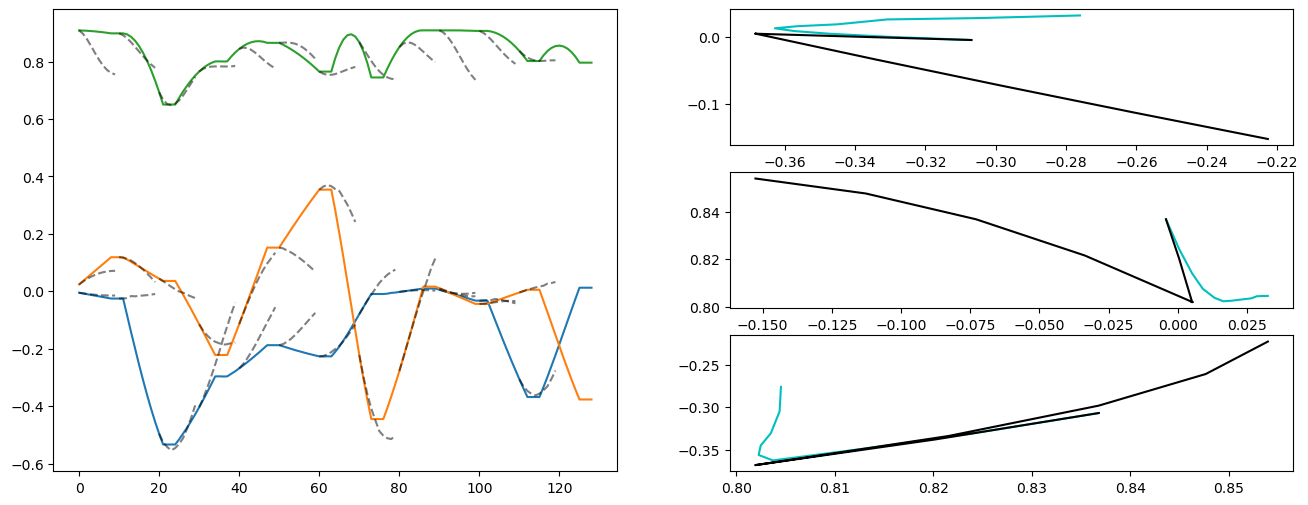

In [194]:
N_TEST = 0

Y_test = X_LTS[N_TEST]
Y_test = Y_test.reshape((Y_test.shape[0], Y_test.shape[1] * Y_test.shape[2]))

Uo_test = np.diff(U[N_TEST], axis=0, prepend=0)
# Uo_test = U[N_TEST]

Z_test, U_test = koopman.gen_delay_traj(Y_test, Uo_test, delay=delay)

fig = plt.figure(figsize=(16,6))

# plt.plot(np.abs(Z_test[:,126:135]))
ax1 = fig.add_subplot(1, 2, 1)
# ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2 = fig.add_subplot(3, 2, 2)
ax3 = fig.add_subplot(3, 2, 4)
ax4 = fig.add_subplot(3, 2, 6)

ax1.plot((Z_test[:,Y_test.shape[1]-3:Y_test.shape[1]]))

look_ahead = 10

for j in range(int(Z_test.shape[0] // look_ahead)):
    X_test = np.zeros((look_ahead, Z_test.shape[1]))
    X_test[0] = Z_test[look_ahead*j]

    for t in range(1, look_ahead):
        X_test[t] = A @ X_test[t-1] + B @ U_test[look_ahead*j+t-1]
    
    ax1.plot(np.arange(look_ahead*j, look_ahead*(j+1)), (X_test[:,Y_test.shape[1]-3:Y_test.shape[1]]), c='k', ls='--', alpha=0.5)

# ax2.plot(X_test[:,27], X_test[:,28], X_test[:,29])
# ax2.plot(Z_test[look_ahead*j:look_ahead*(j+1),27], Z_test[look_ahead*j:look_ahead*(j+1),28], Z_test[look_ahead*j:look_ahead*(j+1),29])
ax2.plot(X_test[:,Y_test.shape[1]-3], X_test[:,Y_test.shape[1]-2], c='c')
ax2.plot(Z_test[look_ahead*j:look_ahead*(j+1),Y_test.shape[1]-3], Z_test[look_ahead*j:look_ahead*(j+1),Y_test.shape[1]-2], c='k')
ax3.plot(X_test[:,Y_test.shape[1]-2], X_test[:,Y_test.shape[1]-1], c='c')
ax3.plot(Z_test[look_ahead*j:look_ahead*(j+1),Y_test.shape[1]-2], Z_test[look_ahead*j:look_ahead*(j+1),Y_test.shape[1]-1], c='k')
ax4.plot(X_test[:,Y_test.shape[1]-1], X_test[:,Y_test.shape[1]-3], c='c')
ax4.plot(Z_test[look_ahead*j:look_ahead*(j+1),Y_test.shape[1]-1], Z_test[look_ahead*j:look_ahead*(j+1),Y_test.shape[1]-3], c='k')



# plt.yscale('log')

## MPPI

In [40]:
# Implementation of https://ieeexplore.ieee.org/document/8558663

class MPPI:
    def __init__(self, A, B, C, Q, R, look_ahead, n_samples, sigma, window, param_exploration, param_lambda, param_alpha, u_max=-1, u_min=1, ua_max=8, ua_min=0):
        '''
        Given a Koopman linear model 
            z_{k+1} = A z_k + B u_k
            x_k = C z_k
        and a reference trajectory
            {r_i, r_{i+1}, ..., r_{i+look_ahead}}
        computes optimal 
            {u_i, u_{i+1}, ..., u_{i+look_ahead}}
        that minimizes
            sum_{j \in [i,i+look_ahead]} (x_j - r_j)^T Q (x_j - r_j) + u_j^T R u_j
        subject to
            0 <= u_i < u_max
        
        This is a quadratic program, but because in Koopman models z is incredibly high dimensional,
            we resort to ussing an information-theoretic based MPPI solver 

        Note that x \in R^N, z \in R^n, u \in R^m

        Args:
            A (np.ndarray): matrix in linear model (n x n)
            B (np.ndarray): matrix in linear model (n x m)
            C (np.ndarray): projection matrix (N x n)
            Q (np.ndarray): weight matrix for state error
            R (np.ndarray): weight matrix for control input magnitude
            look_ahead (float): MPC horizon
            n_samples (float): number of samples for MPPI
            sigma (float): deviation of noise
            window (int): size of moving average window
            param_exploration (float): exploration rate (probably really small)
            param_lambda (float): MPPI lambda parameter
            param_alpha (float): MPPI alpha parameter
            u_max (float): maximum value of u
            u_min (float): minimum value of u
        '''
        self.A = A                                      # n x n
        self.B = B                                      # n x m
        self.C = C                                      # N x n
        self.Q = Q                                      # N x N
        self.R = R                                      # m x m
        self.look_ahead = look_ahead
        self.n_samples = n_samples
        self.sigma = sigma
        self.window = window
        
        self.param_exploration = param_exploration
        self.param_lambda = param_lambda
        self.param_alpha = param_alpha 
        self.param_gamma = self.param_lambda * (1.0 - self.param_alpha)
        
        self.u_max = u_max
        self.u_min = u_min
        self.ua_max = ua_max
        self.ua_min = ua_min

        n = A.shape[1]
        m = B.shape[1]
        N = C.shape[0]
        self.n = n
        self.m = m
        self.N = N

        # MPPI params
        self.u_prev = np.zeros((self.look_ahead, m))

    def solve(self, ref, z_init, u_act):
        u = self.u_prev
        z0 = z_init

        # Buffer
        S = np.zeros((self.n_samples,))

        # Sample noise
        epsilon = self._calc_epsilon()

        # control input buffer w/ noise
        u_buff = np.zeros((self.n_samples, self.look_ahead+1, self.m))
        u_buff[:,0] = u[0][None,None,:]
        z = np.ones((self.n_samples, z0.shape[0])) * z0[None,:]

        n_exploits = int((1. - self.param_exploration) * self.n_samples)

        # loop over timesteps
        for t in range(self.look_ahead):
            # get control input with noise
            # sampling for exploitation
            u_buff[:n_exploits,t+1] = np.clip(u[t][None,:] + epsilon[:n_exploits,t], 
                                              self.u_min,
                                              self.u_max)
                                              # np.maximum(self.u_min, u_act - self.ua_min), 
                                              # np.minimum(self.u_max, self.ua_max - u_act))
            epsilon[:n_exploits,t] = u_buff[:n_exploits,t+1] - u[t][None,:]
            
            # sampling for exploration
            u_buff[n_exploits:,t+1] = np.clip(epsilon[n_exploits:,t], 
                                              self.u_min,
                                              self.u_max)
                                              # np.maximum(self.u_min, u_act - self.ua_min), 
                                              # np.minimum(self.u_max, self.ua_max - u_act))
            epsilon[n_exploits:,t] = u_buff[n_exploits:,t+1]

            # update z
            z = (self.A @ z[:,:,None] + self.B @ u_buff[:,t+1,:,None])[:,:,0]
            x = (self.C @ z[:,:,None])[:,:,0]

            x_err = x - ref[t][None,:]
            # u_err = u_buff[:,t+1] - u_buff[:,t]
            u_err = u_buff[:,t+1]

            # dynamics cost
            S += \
                (x_err[:,None,:] @ self.Q @ x_err[:,:,None])[:,0,0] + \
                (u_err[:,None,:] @ self.R @ u_err[:,:,None])[:,0,0]# + \
                # self.param_gamma * (1 / self.sigma) * (u[t][None,:] @ u_buff[:,t+1,:,None])[:,0,0]


        # Information theoretic weights
        w = self._calc_weights(S)
        w_epsilon = self._calc_average(np.sum(w[:,None,None] * epsilon, axis=0), self.window)
        # print(u + w_epsilon)
        u = np.clip(u + w_epsilon, self.u_min, self.u_max)
        # u = np.clip(w_epsilon, self.u_min, self.u_max)
        
        # u = u_buff[S.argmin(),1:]
        # print(S)

        self.u_prev[:-1] = u[1:]
        self.u_prev[-1] = u[-1]

        return u[0], u


    def _calc_weights(self, S):
        rho = S.min()
        w = np.exp((-1/self.param_lambda) * (S - rho))
        return w / np.sum(w)
    
    def _calc_epsilon(self):
        return np.random.normal(0., self.sigma, size=(self.n_samples, self.look_ahead, self.m))
    
    def _calc_average(self, xx, window_size):
        b = np.ones(window_size)/window_size
        dim = xx.shape[1]
        xx_mean = np.zeros_like(xx)

        for d in range(dim):
            xx_mean[:,d] = np.convolve(xx[:,d], b, mode="same")
            n_conv = int(np.ceil(window_size/2))
            xx_mean[0,d] *= window_size/n_conv
            for i in range(1, n_conv):
                xx_mean[i,d] *= window_size/(i+n_conv)
                xx_mean[-i,d] *= window_size/(i + n_conv - (window_size % 2)) 
        return xx_mean

## KMPC

In [8]:
class KMPC:
    def __init__(self, A, B, C, Q, R, look_ahead, u_max=20, u_min=0, solver='qrqp'):
        '''
        Given a Koopman linear model 
            z_{k+1} = A z_k + B u_k
            x_k = C z_k
        and a reference trajectory
            {r_i, r_{i+1}, ..., r_{i+look_ahead}}
        computes optimal 
            {u_i, u_{i+1}, ..., u_{i+look_ahead}}
        that minimizes
            sum_{j \in [i,i+look_ahead]} (x_j - r_j)^T Q (x_j - r_j) + u_j^T R u_j
        subject to
            0 <= u_i < u_max
        
        This is a quadratic program, solved using cs.Opti('conic')

        Note that x \in R^N, z \in R^n, u \in R^m

        Args:
            A (np.ndarray): matrix in linear model (n x n)
            B (np.ndarray): matrix in linear model (n x m)
            C (np.ndarray): projection matrix (N x n)
            Q (np.ndarray): weight matrix for state error
            R (np.ndarray): weight matrix for control input magnitude
            look_ahead (float): MPC horizon
            u_max (float): maximum value of u
            u_min (float): minimum value of u
        '''

        self.A = A                                      # n x n
        self.B = B                                      # n x m
        self.C = C                                      # N x n
        self.Q = Q                                      # N x N
        self.R = R                                      # m x m
        self.look_ahead = look_ahead
        self.u_max = u_max
        self.u_min = u_min

        n = A.shape[1]
        m = B.shape[1]
        N = C.shape[0]
        self.n = n
        self.m = m
        self.N = N

        ##################
        # Setup optimizer
        if solver in ['qrqp', 'qpoases', 'osqp', 'proxqp']:
            opti = cs.Opti('conic')
        else:
            opti = cs.Opti()

        # Variables
        z_var = opti.variable(n, look_ahead + 1)        # n x (T+1)
        u_var = opti.variable(m, look_ahead)            # m x T
        
        z_int = opti.parameter(n, 1)                    # n x 1
        x_ref = opti.parameter(N, look_ahead + 1)       # N x (T+1)

        # Cost
        cost = 0

        x_comp = C @ z_var                              # (N x n) @ (n x (T+1)) = N x (T+1)
        r_err = (x_comp - x_ref)                        # N x (T+1)
        
        # Dynamics error
        for i in range(1,look_ahead+1):
            cost += r_err[:,i].T @ Q @ r_err[:,i]       # a scalar hopefully
        
        # Control error
        for i in range(1,look_ahead):
            # u_err = u_var[:,i] - u_var[:,i-1]
            u_err = u_var[:,i-1]
            cost += u_err.T @ R @ u_err
        
        # Terminal error
        # cost += 10 * r_err[:,look_ahead].T @ Q @ r_err[:,look_ahead]

        # Dynamics and control constraints
        opti.subject_to(z_var[:,0] == z_int)
        for i in range(look_ahead):
            z_nxt = A @ z_var[:,i] + B @ u_var[:,i]
            opti.subject_to(z_var[:,i+1] == z_nxt)
            
            opti.subject_to(opti.bounded(u_min, u_var[:,i], u_max))
        
        opti.minimize(cost)
        if solver == 'qpoases':
            opti.solver('qpoases', {})
        elif solver == 'qrqp':
            opti.solver('qrqp', 
                # {'print_header': False, 'print_info': False, 'print_iter': False}
            )
        elif solver == 'osqp':
            opti.solver('osqp',
                {'verbose': False, 'print_time': False, 'print_problem': False},
                {'verbose': False}
           )
        elif solver == 'proxqp':
            opti.solver('proxqp',
                        {}
           )
        else:
            opti.solver('ipopt')
        
        self.opti_dict = {
            'opti': opti,
            'z_var': z_var,
            'u_var': u_var,
            'z_int': z_int,
            'x_ref': x_ref,
            'cost': cost
        }
    
    def solve(self, ref, z_init, sol=None):
        opti = self.opti_dict['opti']
        z_var = self.opti_dict['z_var']
        u_var = self.opti_dict['u_var']
        z_int = self.opti_dict['z_int']
        x_ref = self.opti_dict['x_ref']

        if sol is not None:
            opti.set_initial(sol.value_variables())

        opti.set_value(z_int, z_init)
        opti.set_value(x_ref, ref)

        # try:
        sol = opti.solve()
        z_val, u_val = sol.value(z_var), sol.value(u_var)
        return u_val[:,0], sol
        # except RuntimeError as e:
        #     print(f'MPC solution failed with {opti.return_status()}')
        #     print(e)
        #     return np.zeros(self.m), None


## Test

In [9]:
# test_tau = np.random.uniform(0, 3.0, (9))
# test_tau = np.random.uniform(0, 8.0, (3*backbone.n_sections))
# test_tau
# test_tau, test_tau.mean()

# 5 segment figure
# test_tau = np.array([6.93142772, 3.77952324, 3.35596786, 0.58235351, 4.50013011,
#         6.46060242, 7.9504733 , 3.15511226, 2.25133565, 1.42183292,
#         7.67605619, 1.8123319 , 7.84506515, 5.16244479, 1.75914116])
# test_tau = np.array([0.1682174 , 7.99088353, 4.40005255, 1.23275674, 5.79228663,
#        7.95069399, 0.98126184, 1.75497603, 3.10461027, 4.09518758,
#        5.56820503, 5.06379607, 3.03164112, 6.54850583, 5.89239145])

# 3 segment figure
test_tau = np.array([0.40599404, 3.69085594, 2.14859742, 2.61556977, 2.93844975,
       3.77950903, 4.62739448, 4.88464597, 0.73038165])

# Letter R
# test_tau = np.array([
#     0, 0, 0,
#     7, 0, 0,
#     7, 0, 0,
#     0, 8, 8
# ])

# Letter S
# test_tau = np.array([
#     7.5, 0, 0,
#     7.5, 0, 0,
#     0, 7.5, 7.5,
#     0, 7.5, 7.5
# ])


In [10]:
TEST_TRAJ = 2
TEST_TIMESTEP = -1

X = np.zeros((backbone.n * backbone.n_sections, 21))
Xh = np.zeros((backbone.n * backbone.n_sections + 1, 12))
X, Xh, Z, u0 = init(backbone, unpack_tau(backbone, test_tau), X, Xh)

TEST_X = np.array(X)
# TEST_X = Y[TEST_TRAJ,TEST_TIMESTEP]


C = np.eye(Yf.shape[1], Xf.shape[1])
look_ahead = 3

# Q = 1e3*np.eye(Yf.shape[1])
# R = 1e0*np.eye(Uf.shape[1])
# Q = 2e1*np.eye(Yf.shape[1])
# Q = 1e2*np.diag(np.repeat(np.arange(Yf.shape[1]//3)+1, 3))**1
Q = 2e1*np.diag(np.repeat(np.arange(Yf.shape[1]//3)[::-1]+1, 3))**(0.9)
R = 5e0*np.eye(Uf.shape[1])

controller = KMPC(
    A, B, C, Q, R, 
    look_ahead, 
    # u_max=1e-2, u_min=-1e-2,
    # u_max=5e-2, u_min=-5e-2,
    u_max=1e-1, u_min=-1e-1,
    # u_max=8, u_min=0,
    solver='osqp'
)
# controller = MPPI(
#     A, B, C, Q, R,
#     look_ahead, 1000,
#     sigma=5e-3,
#     window=1,
#     param_exploration=1,
#     param_lambda=0.25,
#     param_alpha=0.75,
#     # u_max= 0.25,
#     # u_min=-0.25
#     u_max = 8,
#     u_min = 0
# )

# Setup simulator
X = np.zeros((backbone.n * backbone.n_sections, 21))
Xh = np.zeros((backbone.n * backbone.n_sections + 1, 12))
dt = backbone.dt

n_tendons = int(backbone.n_tendons)

tau = np.zeros(n_tendons)
# tau = U[TEST_TRAJ, TEST_TIMESTEP]
# controller.u_prev = np.ones((controller.look_ahead, controller.m)) * tau[None,:]
X, Xh, Z, u0 = init(backbone, unpack_tau(backbone, tau), X, Xh)

# Delay coordinate setup
z, _, _, _, _ = make_mats(np.tile(X, (1, delay+2, 1, 1)), np.zeros((1,delay+2,1)), backbone, delay=delay, freq=freq)
z = z[0]

# Reference configuration
_, _, _, ref_tmp, _ = make_mats(np.tile(TEST_X, (1, delay+2, 1, 1)), np.zeros((1,delay+2,1)), backbone, delay=delay, freq=freq)
ref_tmp = ref_tmp[0,0].flatten()
ref = np.ones((look_ahead+1, Yf.shape[1])) * ref_tmp[None,:]

NT = 200    # Number of control inputs
NP = 1     # Number of timesteps in between control inputs


Xfull = np.zeros((NT*NP+1, backbone.n * backbone.n_sections, 21))
Xfull[0] = X
Ufull = np.zeros((NT*NP+1, Uf.shape[1]))
Ufull[0] = tau
Ubuff = np.zeros((NT+1, Uf.shape[1]))
Ubuff[0] = tau
Uraw = np.zeros((NT, Uf.shape[1]))
sol = None

for i in tqdm(range(NT)):
    # Get control input for current z
    # inp, inp_f = controller.solve(ref, z, Ubuff[i])
    inp, sol = controller.solve(ref.T, z, sol=sol)
    Ubuff[i+1] = Ubuff[i] + inp
    # Ubuff[i+1] = inp
    Uraw[i] = inp
    
    # Propagate ground truth forward by interpolating to new control input
    for j in range(1,NP+1):
        theta = j / NP
        tau = np.clip(Ubuff[i] * (1 - theta) + Ubuff[i+1] * theta, 0, 8)
        # tau = Ubuff[i] * (1 - theta) + Ubuff[i+1] * theta
        # print(Ubuff[i-1], inp, tau)
        X, Xh, Z, u0 = step(backbone, unpack_tau(backbone, tau), X, Xh, Z, u0)
        
        Xfull[NP*i+j] = X
        Ufull[NP*i+j] = tau

    # Shift z
    z[Yf.shape[1]:] = z[:len(z)-Yf.shape[1]]
    
    # Project out the reference configuration
    _, _, _, z_tmp, _ = make_mats(np.tile(X, (1, delay+2, 1, 1)), np.zeros((1,delay+2,1)), backbone, delay=delay, freq=freq)
    z_tmp = z_tmp[0,0].flatten()
    z[:Yf.shape[1]] = z_tmp


100%|██████████| 200/200 [00:58<00:00,  3.42it/s]


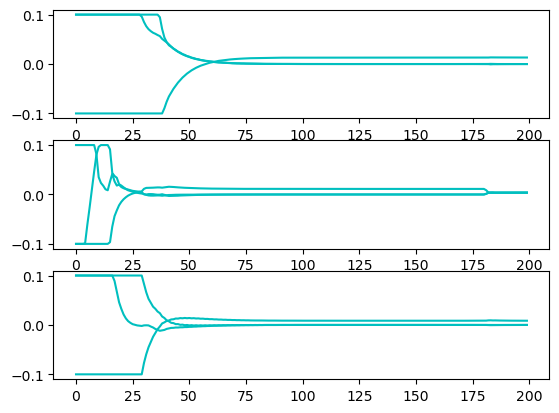

In [11]:
U_ref = U[TEST_TRAJ, TEST_TIMESTEP]

fig = plt.figure()

for sec_i in range(backbone.n_sections):
    ax = fig.add_subplot(backbone.n_sections, 1, backbone.n_sections - sec_i)
    # ax2.plot(Ufull[:,0:3])
    ax.plot(Uraw[:,sec_i*3:(sec_i+1)*3], c='c')
    # for u in U_ref[0:3]:
    #     ax2.axhline(u, c='k', ls='--')


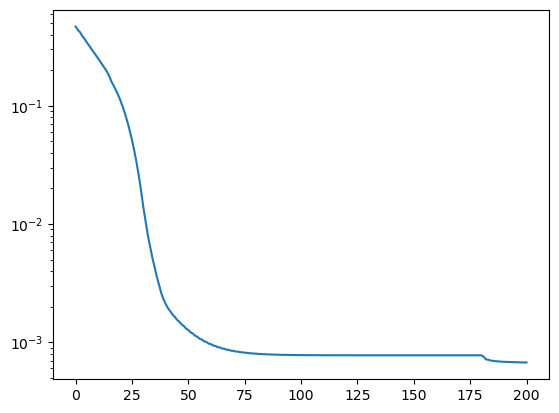

In [12]:
plt.plot(np.mean(np.power(TEST_X[:,:3][None,:,:] - Xfull[:,:,:3], 2), axis=(1,2)))

plt.yscale('log')

In [13]:
np.savez_compressed('test_r_3', Xfull=Xfull, TEST_X=TEST_X)

In [ ]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1, 2, 1, projection='3d')

L = backbone.L * backbone.n_sections * 1.2

o = np.ones(Xfull.shape[1])
x_line = ax.plot(-(L/2) * o,   Xfull[0,:,1], Xfull[0,:,2], c='gray')[0]
y_line = ax.plot(Xfull[0,:,0], (L/2) * o,    Xfull[0,:,2], c='gray')[0]
z_line = ax.plot(Xfull[0,:,0], Xfull[0,:,1], 0.0 * o, c='gray')[0]

# tendons
alpha = 0.75
cmap = plt.get_cmap('copper')
p, R, _, _, _ = unpack(Xfull[0])
# tnd = []
# j = 0
# for sec_i, tendon in enumerate(backbone.tendons):
#     tnd.append([])

#     for k in range(tendon.n_tendons):
#         r = (p[backbone.n*sec_i:backbone.n*(sec_i+1)] + (R[backbone.n*sec_i:backbone.n*(sec_i+1)] @ tendon.r[k,:,None]))[:,:,0]
#         tnd[-1].append(ax.plot(r[:,0], r[:,1], r[:,2], c=cmap(256 * Ufull[0,j]/20), alpha=alpha)[0])

#         j += 1

line = ax.plot(Xfull[0,:,0], Xfull[0,:,1], Xfull[0,:,2], c='b')[0]

# ref_line = ax.plot(Y[TEST_TRAJ, TEST_TIMESTEP,:,0], Y[TEST_TRAJ, TEST_TIMESTEP,:,1], Y[TEST_TRAJ, TEST_TIMESTEP,:,2], c='k', ls='--')[0]
ref_line = ax.plot(TEST_X[:,0], TEST_X[:,1], TEST_X[:,2], c='k', ls='--')[0]
ax.plot(TEST_X[:,0], TEST_X[:,1], np.zeros_like(TEST_X[:,2]), c='k', ls='--', alpha=0.5)[0]
ax.plot(TEST_X[:,0], (L/2) * np.ones_like(TEST_X[:,1]), TEST_X[:,2], c='k', ls='--', alpha=0.5)[0]
ax.plot(-(L/2) * np.ones_like(TEST_X[:,0]), TEST_X[:,1], TEST_X[:,2], c='k', ls='--', alpha=0.5)[0]

# ax.view_init(elev=10., azim=90)

ax.set_xlim(-(L/2), (L/2))
ax.set_ylim(-(L/2), (L/2))
ax.set_zlim(0, L)

ticks = []
for sec_i in range(backbone.n_sections):
    axf = fig.add_subplot(backbone.n_sections, 2, 2*(backbone.n_sections - sec_i))
    axf.plot(Ufull[:,sec_i*3:(sec_i+1)*3], c='c')
    ticks.append(axf.axvline(0, c='k'))

plt.tight_layout()

anim_freq = 1

def animate(i):
    i = anim_freq * i
    x_line.set_data_3d(-(L/2) * o, Xfull[i,:,1], Xfull[i,:,2])
    y_line.set_data_3d(Xfull[i,:,0],  (L/2) * o, Xfull[i,:,2])
    z_line.set_data_3d(Xfull[i,:,0], Xfull[i,:,1],    0.0 * o)
    
    line.set_data_3d(Xfull[i,:,0], Xfull[i,:,1], Xfull[i,:,2])

    ax.set_xlim(-(L/2), (L/2))
    ax.set_ylim(-(L/2), (L/2))
    ax.set_zlim(0, L)

    for tick in ticks:
        tick.set_xdata([i])
    
    # p, R, _, _, _ = unpack(Xfull[i])
    # j = 0
    # for sec_i, tendon in enumerate(backbone.tendons):
    #     for k in range(tendon.n_tendons):
    #         r = (p[backbone.n*sec_i:backbone.n*(sec_i+1)] + (R[backbone.n*sec_i:backbone.n*(sec_i+1)] @ tendon.r[k,:,None]))[:,:,0]
    #         tnd[sec_i][k].set_data_3d(r[:,0], r[:,1], r[:,2])
    #         tnd[sec_i][k].set_color((*cmap(256 * Ufull[i,j]/20)[:3], alpha))

    #         j += 1


anim = animation.FuncAnimation(
    fig, animate, len(Xfull) // anim_freq, interval=75
)

# FFwriter = animation.FFMpegWriter(fps=10)
# anim.save('animation.mp4', writer = FFwriter)

plt.close()

anim

In [147]:
np.savez_compressed('R_shape', Xfull=Xfull, TEST_X=TEST_X)

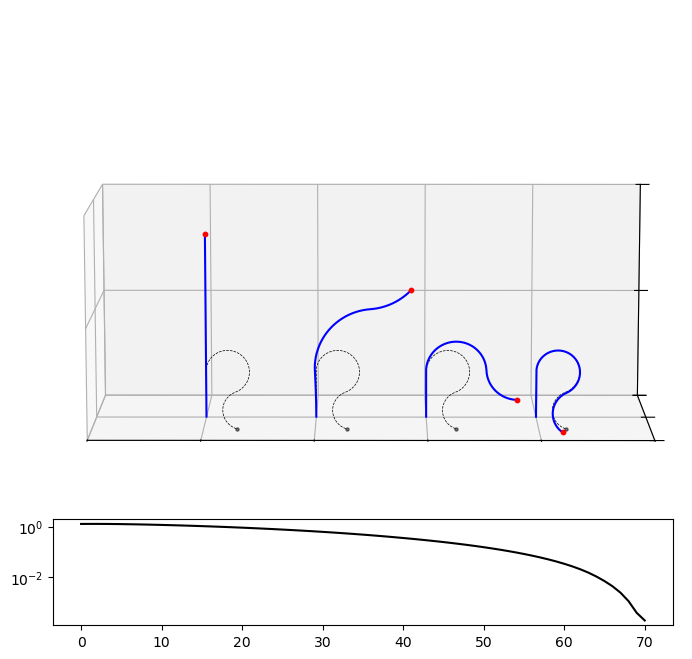

In [146]:
fig = plt.figure(figsize=(8,8))
L = backbone.L * backbone.n_sections * 1.2
o = np.ones(Xfull.shape[1])

inds = [0, 25, 50, 70]

# ax = fig.add_subplot(2, 1, 1, projection='3d')
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.set_xlim(-(L/2)*2, (L/2)*3)
ax.set_ylim(-(L/2), (L/2))
ax.set_zlim(0, L)
ax.set_box_aspect(aspect=(2.5,1,1))

ax.view_init(elev=10, azim=-89.9)

xticks = np.linspace(-(L/2)*2, (L/2)*3, 6)
yticks = np.linspace(-(L/2), (L/2), 3)
zticks = np.linspace(0, L, 3)
empty_labels_x = ["" for i in range(len(xticks))]
empty_labels_y = ["" for i in range(len(yticks))]
empty_labels_z = ["" for i in range(len(zticks))]


for i in range(4):
    num = i+1
    # if i > 1:
    #     num += 4
    
    ax.set_xticks(xticks, empty_labels_x)
    ax.set_yticks(yticks, empty_labels_y)
    ax.set_zticks(zticks, empty_labels_z)
    # ax.set_xticks([])
    # ax.set_yticks([])
    # ax.set_zticks([])

    j = inds[i]
    # ax.plot(-(L/2) * o,   Xfull[j,:,1], Xfull[j,:,2], c='b', alpha=0.5)[0]
    # ax.plot(Xfull[j,:,0], (L/2) * o,    Xfull[j,:,2], c='gray')[0]
    # ax.plot(Xfull[j,:,0], Xfull[j,:,1], 0.0 * o, c='gray')[0]

    
    ref_line = ax.plot(TEST_X[:,0] + (L/2) * (num-2), TEST_X[:,1], TEST_X[:,2], c='k', lw=0.5, ls='--')[0]
    ax.scatter(TEST_X[-1,0] + (L/2) * (num-2), TEST_X[-1,1], TEST_X[-1,2], c='k', s=5, alpha=0.5)

    ax.plot(Xfull[j,:,0] + (L/2) * (num-2), Xfull[j,:,1], Xfull[j,:,2], c='b')[0]
    ax.scatter(Xfull[j,-1,0] + (L/2) * (num-2), Xfull[j,-1,1], Xfull[j,-1,2], c='r', s=10)

ax = fig.add_subplot(5, 1, 5)
ax.plot(np.mean(np.power(TEST_X[:,:3][None,:,:] - Xfull[:,:,:3], 2), axis=(1,2))[:71], c='k')
ax.set_yscale('log')

In [152]:
np.savez_compressed('S_shape', Xfull=Xfull, TEST_X=TEST_X)

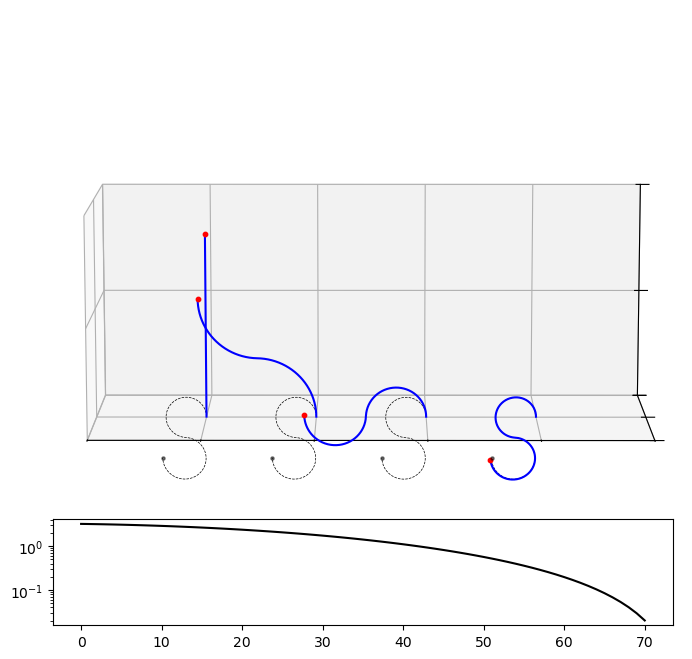

In [153]:
fig = plt.figure(figsize=(8,8))
L = backbone.L * backbone.n_sections * 1.2
o = np.ones(Xfull.shape[1])

inds = [0, 25, 50, 75]

# ax = fig.add_subplot(2, 1, 1, projection='3d')
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.set_xlim((L/2)*3, -(L/2)*2)
ax.set_ylim(-(L/2), (L/2))
ax.set_zlim(0, L)
ax.set_box_aspect(aspect=(2.5,1,1))

ax.view_init(elev=10, azim=-89.9)

xticks = np.linspace(-(L/2)*2, (L/2)*3, 6)
yticks = np.linspace(-(L/2), (L/2), 3)
zticks = np.linspace(0, L, 3)
empty_labels_x = ["" for i in range(len(xticks))]
empty_labels_y = ["" for i in range(len(yticks))]
empty_labels_z = ["" for i in range(len(zticks))]


for i in range(4):
    num = i+1
    # if i > 1:
    #     num += 4
    
    ax.set_xticks(xticks, empty_labels_x)
    ax.set_yticks(yticks, empty_labels_y)
    ax.set_zticks(zticks, empty_labels_z)
    # ax.set_xticks([])
    # ax.set_yticks([])
    # ax.set_zticks([])

    j = inds[i]
    # ax.plot(-(L/2) * o,   Xfull[j,:,1], Xfull[j,:,2], c='b', alpha=0.5)[0]
    # ax.plot(Xfull[j,:,0], (L/2) * o,    Xfull[j,:,2], c='gray')[0]
    # ax.plot(Xfull[j,:,0], Xfull[j,:,1], 0.0 * o, c='gray')[0]

    
    ref_line = ax.plot(TEST_X[:,0] + (L/2) * (3-num), TEST_X[:,1], TEST_X[:,2], c='k', lw=0.5, ls='--')[0]
    ax.scatter(TEST_X[-1,0] + (L/2) * (3-num), TEST_X[-1,1], TEST_X[-1,2], c='k', s=5, alpha=0.5)

    ax.plot(Xfull[j,:,0] + (L/2) * (3-num), Xfull[j,:,1], Xfull[j,:,2], c='b')[0]
    ax.scatter(Xfull[j,-1,0] + (L/2) * (3-num), Xfull[j,-1,1], Xfull[j,-1,2], c='r', s=10)

ax = fig.add_subplot(5, 1, 5)
ax.plot(np.mean(np.power(TEST_X[:,:3][None,:,:] - Xfull[:,:,:3], 2), axis=(1,2))[:71], c='k')
ax.set_yscale('log')

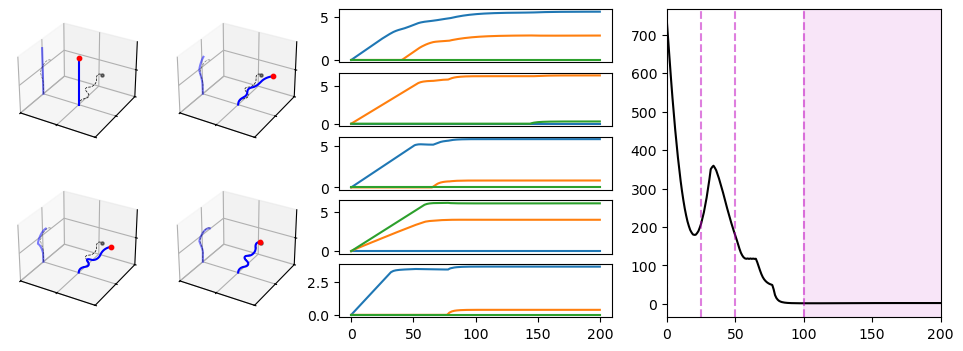

In [108]:
fig = plt.figure(figsize=(12,4))

L = backbone.L * backbone.n_sections * 1.2
o = np.ones(Xfull.shape[1])

inds = [0, 25, 50, 100]

for i in range(4):
    num = i+1
    if i > 1:
        num += 4
    ax = fig.add_subplot(2, 6, num, projection='3d')
    ax.set_xlim(-(L/2), (L/2))
    ax.set_ylim(-(L/2), (L/2))
    ax.set_zlim(0, L)
    
    xticks = np.arange(-(L/2), (L/2), 3)
    yticks = np.arange(-(L/2), (L/2), 3)
    zticks = np.arange(0, L, 3)
    empty_labels_x = ["" for i in range(len(xticks))]
    empty_labels_y = ["" for i in range(len(yticks))]
    empty_labels_z = ["" for i in range(len(zticks))]

    ax.set_xticks(xticks, empty_labels_x)
    ax.set_yticks(yticks, empty_labels_y)
    ax.set_zticks(zticks, empty_labels_z)
    # ax.set_xticks([])
    # ax.set_yticks([])
    # ax.set_zticks([])

    j = inds[i]
    ax.plot(-(L/2) * o,   Xfull[j,:,1], Xfull[j,:,2], c='b', alpha=0.5)[0]
    # ax.plot(Xfull[j,:,0], (L/2) * o,    Xfull[j,:,2], c='gray')[0]
    # ax.plot(Xfull[j,:,0], Xfull[j,:,1], 0.0 * o, c='gray')[0]

    
    ref_line = ax.plot(TEST_X[:,0], TEST_X[:,1], TEST_X[:,2], c='k', lw=0.5, ls='--')[0]
    # ax.plot(TEST_X[:,0], TEST_X[:,1], np.zeros_like(TEST_X[:,2]), c='k', ls='--', alpha=0.5)[0]
    # ax.plot(TEST_X[:,0], (L/2) * np.ones_like(TEST_X[:,1]), TEST_X[:,2], c='k', ls='--', alpha=0.5)[0]
    ax.plot(-(L/2) * np.ones_like(TEST_X[:,0]), TEST_X[:,1], TEST_X[:,2], c='k', ls='--', alpha=0.5, lw=0.5)[0]
    ax.scatter(TEST_X[-1,0], TEST_X[-1,1], TEST_X[-1,2], c='k', s=5, alpha=0.5)

    ax.plot(Xfull[j,:,0], Xfull[j,:,1], Xfull[j,:,2], c='b')[0]
    ax.scatter(Xfull[j,-1,0], Xfull[j,-1,1], Xfull[j,-1,2], c='r', s=10)

for sec_i in range(backbone.n_sections):
    ax = fig.add_subplot(backbone.n_sections, 3, (backbone.n_sections - sec_i - 1)*3 + 2)
    ax.plot(Ufull[:,sec_i*3:(sec_i+1)*3])
    if sec_i != 0:
        ax.set_xticks([])
    
ax = fig.add_subplot(1, 3, 3)
err = np.sum(np.power(TEST_X[:,:3][None,:,:] - Xfull[:,:,:3], 2), axis=(1,2))
ax.plot(err, c='k')
# ax.set_yscale('log')

for ind in inds:
    ax.axvline(ind, ls='--', alpha=0.5, c='m')

lb_err = np.min(err)
ub_err = np.max(err)
rn_err = ub_err - lb_err
ax.set_ylim(lb_err - rn_err*0.05, ub_err + rn_err*0.05)
ax.set_xlim(0, len(Xfull)-1)

fll = np.arange(inds[-1], len(Xfull)+5, 2)
ax.fill_between(fll, fll * (lb_err - rn_err*0.05), fll * (ub_err + rn_err*0.05), color='m', alpha=0.1)

# plt.tight_layout()

plt.savefig('s5results', dpi=300)

# Figures

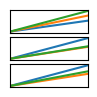

In [153]:
# three tendon sample fig

core_num = 1
test_num = 8

fig_Y, fig_U = load_file('data_333/' + f'out_{core_num}_{test_num}.npz')

fig, axs = plt.subplots(3, 1, figsize=(1,1), sharex=True)

axs[0].plot(fig_U[0:11, 0:3])
axs[1].plot(fig_U[0:11, 3:6])
axs[2].plot(fig_U[0:11, 6:9])

# plt.setp(axs[0].get_xticklabels(), visible=False)
# plt.setp(axs[1].get_xticklabels(), visible=False)

axs[0].get_xaxis().set_ticks([])
axs[1].get_xaxis().set_ticks([])
axs[2].get_xaxis().set_ticks([])
axs[0].get_yaxis().set_ticks([])
axs[1].get_yaxis().set_ticks([])
axs[2].get_yaxis().set_ticks([])

axs[0].set_xlim(0, 10)

plt.savefig('test.svg')